# Plot Multiple scans using Gui widgets

To use this notebook:
 1. press shift+enter in the first three cells
 2. Below Cell 3 Make sure your root directory, inturment and experiment number are correct
 3. Press Find scans
 4. select the scans you want to plot together
 5. Press Load
 6. Choose the plot type
 7. select the x and y axis. 
    - The default x is obtained from the first scan. 
    - There is no default y so be sure to select it
    - the color for pcolor or the height in the waterfall is always the detector column.

Each time you press plot, another figure will appear

In [1]:
import collections
import ipywidgets as ipyw
import os
import numpy as np
import neutronpy as npy
%matplotlib inline
from IPython.display import display

In [2]:
class Dir_builder(object):
    
    def __init__(self,instr_lst=['HB1','HB1A','HB3','CTAX'],root_dir=r"/HFIR/",exp_num=718):
       """
       """
       self.instr_mgn='0px 20px 10px 10px'
       self.dir_path=ipyw.Text(value=root_dir)
       self.instr_name=ipyw.Dropdown(options=instr_lst,value='HB1A',layout=ipyw.Layout(max_width='70px',margin=self.instr_mgn))
       self.exp_name=ipyw.Text(value=str(exp_num),layout=ipyw.Layout(width='50px'),margin='0px 10px 10px 10px')
       self.find_button=ipyw.Button(description='Find scans')
       self.row1=ipyw.HBox([ipyw.Label('Root Directory'),self.dir_path])
       self.row2=ipyw.HBox([ipyw.Label('Instrument'),self.instr_name, ipyw.Label('Experiment #'),self.exp_name])
       self.row3=self.find_button
       self.scans_info=ipyw.VBox([self.row1,self.row2,self.row3])
       display(self.scans_info) 
       self.find_button.on_click(self.display_scans)
       self.sel_fls=None
       self.scans_obj=None
       self.plot_column=None
    
    def assemble_directory(self):
        """
        """
        #print("hello")
        #print (self.instr_name.value,self.exp_name.value)
        self.data_path=self.dir_path.value+self.instr_name.value+os.sep+'exp'+self.exp_name.value+os.sep+'Datafiles'+os.sep
    def display_scans(self,b):
        """
        """
        self.assemble_directory()
        #print (self.data_path)
        out_list=scans_list(self.data_path)
        height_str=str(np.int(np.ceil(len(out_list)*16.5)))+'px'
        if self.sel_fls==None:
            self.Load_button=ipyw.Button(description="Load")
            self.sel_fls=ipyw.widgets.SelectMultiple(name='scans',options=out_list,layout=ipyw.Layout(height=height_str))
            self.col=ipyw.VBox([self.sel_fls,self.Load_button])
            display(self.col)
            self.Load_button.on_click(self.load_scans)
        else:
            self.sel_fls.height=height_str
            self.sel_fls.options=out_list
    
    def load_scans(self,b):
        scan_dict=collections.OrderedDict()
        for fl in self.sel_fls.value:
            scan_dict[fl]=npy.fileio.load_data(str(self.data_path+fl))
        self.scans_obj=npy.data.Scans(scan_dict)
        # determine the colum names from the first column.  Need something more general/
        sing_scan=self.scans_obj.scans[self.sel_fls.value[0]]
        ta=list(map(lambda x: len(x),sing_scan.data_columns))
        max_wstr=str(np.array(ta).max()*9)+'px'
        if self.plot_column==None:
           self.plot_type=ipyw.RadioButtons(options=['pcolor','waterfall'],value='pcolor')    
           self.xaxis=ipyw.Select(options=sing_scan.data_columns,value=sing_scan.plot_default_x,layout=ipyw.Layout(width=max_wstr))
           self.yaxis=ipyw.Select(options=sing_scan.data_columns,layout=ipyw.Layout(width=max_wstr))
           self.axis_row=ipyw.HBox([ipyw.Label('x axis'),self.xaxis,ipyw.Label('y axis'),self.yaxis])
           self.plot_button=ipyw.Button(description="Plot")
           self.plot_column=ipyw.VBox([self.plot_type,self.axis_row,self.plot_button])
           display(self.plot_column)
           self.plot_button.on_click(self.make_plot)
        else:
           self.xaxis.options=sing_scan.data_columns
           self.xaxis.value=sing_scan.plot_default_x
           self.yaxis.options=sing_scan.data_columns
    
    def make_plot(self,b):
        if self.plot_type.value=='pcolor':
            self.scans_obj.pcolor(self.xaxis.value,self.yaxis.value)
        if self.plot_type.value=='waterfall':    
            self.scans_obj.waterfall(self.xaxis.value,label_column=self.yaxis.value,offset=5000)                     

#some helper functions                
def scans_list(data_path):
    """
    return a list of files in the given directory with only the .dat extension
    """
    fl_list=os.listdir(data_path)
    dat_list=sorted(list(filter(lambda x:x.find('.dat')>0, fl_list)))
    return dat_list

def box_width(in_lst):
    """
    given a list of strings,  return the length of the longest in pixels
    """
    ta=list(map(lambda x: len(x),in_lst))
    wstr=str(np.array(ta).max()*9)+'px'
    return wstr

    

/SNS/users/19g/miniconda/envs/tas/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


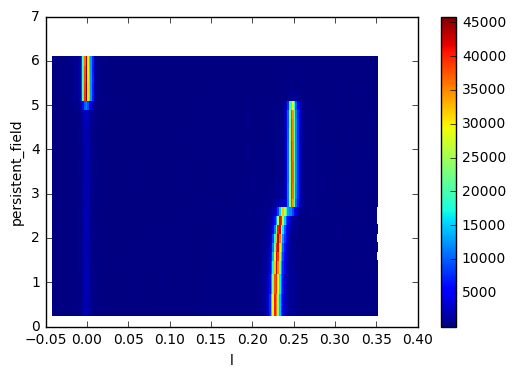

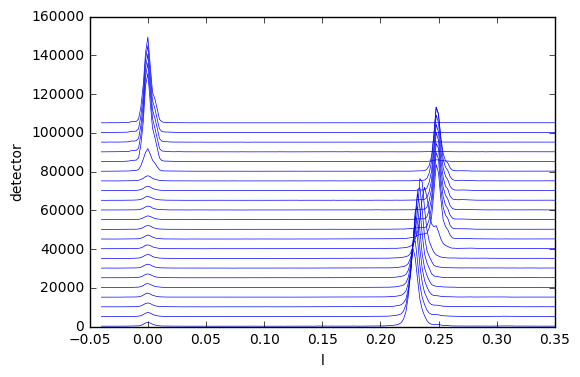

In [3]:
scans_finder=Dir_builder()
